# Hybrid Demucs

Feel free to use the Colab version:
https://colab.research.google.com/drive/1dC9nVxk3V_VPjUADsnFu8EiT-xnU1tGH?usp=sharing

In [ ]:
#!pip install -U demucs
# or for local development, if you have a clone of Demucs
# pip install -e .

In [37]:
# You can use the `demucs` command line to separate tracks
!demucs song1/song1.wav

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\Arthur Viens\Desktop\dev\demucs\separated\htdemucs
Separating track song1\song1.wav



  0%|                                                                                 | 0.0/204.75 [00:00<?, ?seconds/s]
  3%|██                                                                      | 5.85/204.75 [00:34<19:23,  5.85s/seconds]
  6%|████                                                                    | 11.7/204.75 [00:49<12:37,  3.92s/seconds]
  9%|████▉                                                     | 17.549999999999997/204.75 [01:05<10:33,  3.38s/seconds]
 11%|████████▏                                                               | 23.4/204.75 [01:19<09:06,  3.01s/seconds]
 14%|██████████▏                                                            | 29.25/204.75 [01:33<08:09,  2.79s/seconds]
 17%|█████████▉                                                | 35.099999999999994/204.75 [01:48<07:37,  2.69s/seconds]
 20%|███████████▌                                              | 40.949999999999996/204.75 [02:02<07:06,  2.61s/seconds]
 23%|████████████████▍         

In [2]:
# You can also load directly the pretrained models,
# for instance for the MDX 2021 winning model of Track A:
from demucs import pretrained
model = pretrained.get_model('mdx')


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/0d19c1c6-0f06f20e.th" to C:\Users\Arthur Viens/.cache\torch\hub\checkpoints\0d19c1c6-0f06f20e.th


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/7ecf8ec1-70f50cc9.th" to C:\Users\Arthur Viens/.cache\torch\hub\checkpoints\7ecf8ec1-70f50cc9.th


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/c511e2ab-fe698775.th" to C:\Users\Arthur Viens/.cache\torch\hub\checkpoints\c511e2ab-fe698775.th


  0%|          | 0.00/160M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/7d865c68-3d5dd56b.th" to C:\Users\Arthur Viens/.cache\torch\hub\checkpoints\7d865c68-3d5dd56b.th


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [42]:
import torch

def numel(m: torch.nn.Module, only_trainable: bool = False):
    assert isinstance(m, torch.nn.Module), f"{type(m)} is not a nn.Module"
    parameters = list(m.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

for i in range(4):
    print(f"Number of parameters {numel(model.models[i])}")

Number of parameters 88984040
Number of parameters 88984040
Number of parameters 83607872
Number of parameters 83884248


(8843231, 2)


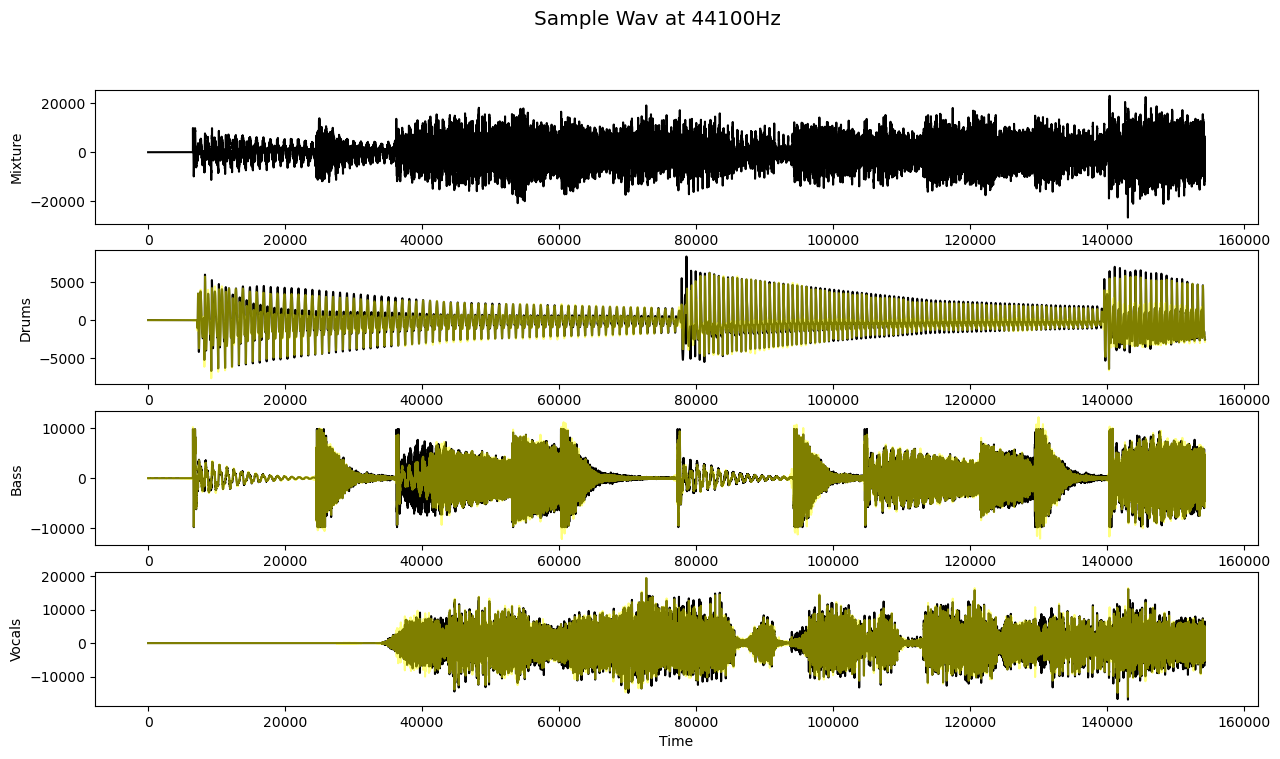

In [36]:
from scipy.io import wavfile
import matplotlib.pyplot as plt

samplerate, mix = wavfile.read('./song1/song1.wav')
_, drums = wavfile.read('./song1/drums.wav')
_, bass = wavfile.read('./song1/bass.wav')
_, vocals = wavfile.read('./song1/vocals.wav')

_, dmxd_drums = wavfile.read('./separated/htdemucs/song1/drums.wav')
_, dmxd_bass = wavfile.read('./separated/htdemucs/song1/bass.wav')
_, dmxd_vocals = wavfile.read('./separated/htdemucs/song1/vocals.wav')

label = ["Mixture", "Drums", "Bass", "Vocals"]
print(mix.shape)

# plot the first 1024 samples
fig, ax = plt.subplots(figsize=(15,8), nrows=4)

plt.xlabel("Time")
fig.suptitle(f"Sample Wav at {samplerate}Hz", fontsize="x-large")
ax[0].plot(mix[int(1.5*44100):5*44100, 0], color="black")
ax[1].plot(bass[int(1.5*44100):5*44100, 0], color="black")
ax[1].plot(dmxd_bass[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
ax[2].plot(drums[int(1.5*44100):5*44100, 0], color="black")
ax[2].plot(dmxd_drums[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
ax[3].plot(vocals[int(1.5*44100):5*44100, 0], color="black")
ax[3].plot(dmxd_vocals[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
for i, axe in enumerate(ax):
    axe.set_ylabel(label[i])
plt.show()

In [3]:
# Because `model` is a bag of 4 models, you cannot directly call it on your data,
# but the `apply_model` will know what to do of it.
import torch
from demucs.apply import apply_model
x = torch.randn(1, 2, 44100 * 10)  # ten seconds of white noise for the demo
out = apply_model(model, x)[0]     # shape is [S, C, T] with S the number of sources

# So let see, where is all the white noise content is going ?
for name, source in zip(model.sources, out):
    print(name, source.std() / x.std())
# The outputs are quite weird to be fair, not what I would have expected.

drums tensor(3.7992)
bass tensor(0.0490)
other tensor(6.5894)
vocals tensor(7.0683)


In [4]:
# now let's take a single model from the bag, and let's test it on a pure cosine
freq = 440  # in Hz
sr = model.samplerate
t = torch.arange(10 * sr).float() / sr
x = torch.cos(2 * 3.1416 * freq * t).expand(1, 2, -1)
sub_model = model.models[3]
out = sub_model(x)[0]

# Same question where does it go?
for name, source in zip(model.sources, out):
    print(name, source.std() / x.std())
    
# Well now it makes much more sense, all the energy is going
# in the `other` source.
# Feel free to try lower pitch (try 80 Hz) to see what happens !

drums tensor(0.0043, grad_fn=<DivBackward0>)
bass tensor(0.0009, grad_fn=<DivBackward0>)
other tensor(0.9943, grad_fn=<DivBackward0>)
vocals tensor(0.0008, grad_fn=<DivBackward0>)


In [ ]:
# For training or more fun, refer to the Demucs README on our repo
# https://github.com/facebookresearch/demucs/tree/main/demucs